In [9]:
# Importing necessary librariesÇ
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.colors import Normalize
from scipy.integrate import odeint
# Defining default values for graph plotting
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 15})

In [10]:
# Setting the exogenous parameters
A = 1
alpha = 0.3
delta = 0.05
rho = 0.02
theta = 0.5
# How fine the grid will be
fine = 60
# How far from the steady state the values to plot:
far = 1.5

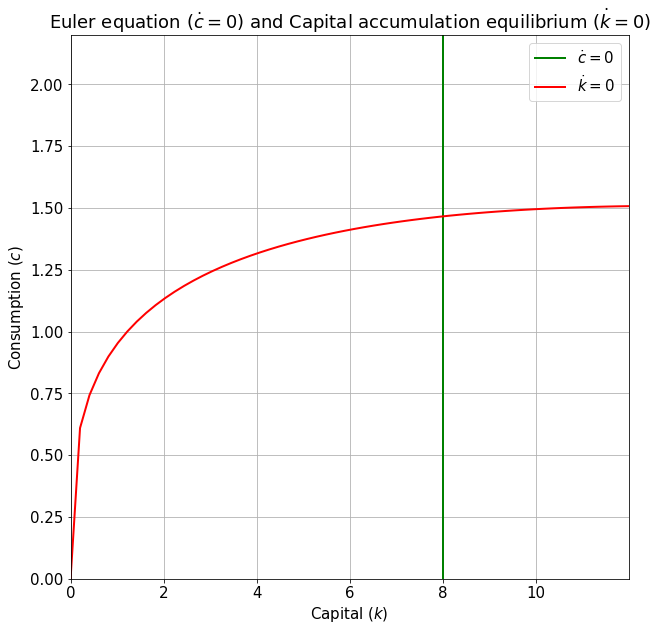

In [11]:
# Finding the steady state values of capital and consumption:
k_ss =  (A*alpha/(delta + rho))**(1/(1-alpha))
c_ss = A*k_ss**alpha - delta*k_ss


# Defining the grid for consumption and capital:
k_grid = np.linspace(0.0,far*k_ss , fine)
c_grid = np.linspace(0.0,far*c_ss , fine)


# Define the two nullcline equations
c_null = (A*alpha/(delta + rho))**(1/(1-alpha))
k_null = A*k_grid**alpha - delta*k_grid

# Defining a function to return the elements of the graph with the nullclines:
def simple_graph():
    plt.plot([c_null]*fine ,c_grid, color = 'green', label='$\\dot c = 0$', linewidth=2)
    plt.plot( k_grid, k_null, color='red' ,label='$\\dot k = 0$', linewidth=2)
    plt.xlabel('Capital ($k$)')
    plt.ylabel('Consumption ($c$)')
    plt.ylim(c_grid[0],c_grid[-1])
    plt.xlim(k_grid[0],k_grid[-1])
    plt.legend()
    plt.grid()

# Plotting the nullclines:
plt.title('Euler equation ($\dot c = 0$) and Capital accumulation equilibrium ($\dot k = 0$)')
simple_graph()
plt.show()

In [12]:
# Define the differential equations
def dc_dk(c, k, A, alpha, delta, rho,theta):
    dc = c*(A*alpha*k**(alpha-1) - delta - rho)/theta
    dk = A*k**alpha - delta*k - c
    return dc, dk

# Setting the grids to be used in the phase diagram:
M1, M2 = np.meshgrid(c_grid, k_grid)

# Evaluating the differential equations on the grids:
dc_grid, dk_grid = dc_dk(M1,M2, A, alpha, delta, rho,theta)

C:\Users\pedro\AppData\Local\Temp\ipykernel_2552\4007330340.py:3: RuntimeWarning: divide by zero encountered in power
  dc = c*(A*alpha*k**(alpha-1) - delta - rho)/theta
C:\Users\pedro\AppData\Local\Temp\ipykernel_2552\4007330340.py:3: RuntimeWarning: invalid value encountered in multiply
  dc = c*(A*alpha*k**(alpha-1) - delta - rho)/theta


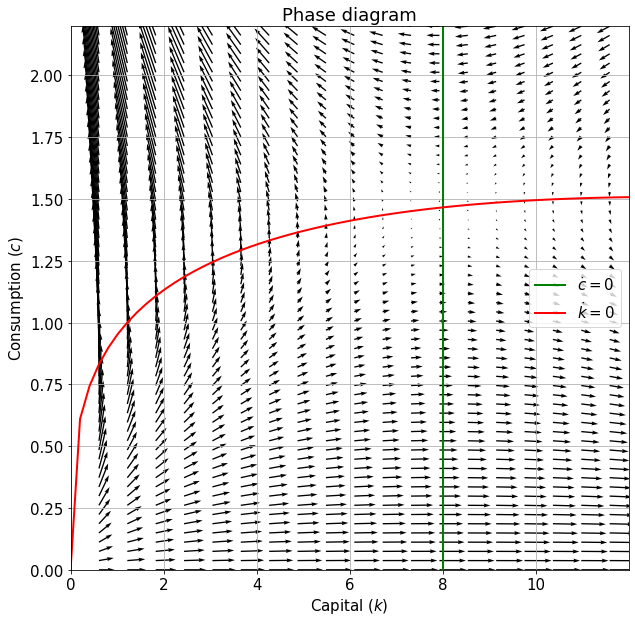

In [13]:
# Plot the direction field
plt.title('Phase diagram')
# Since the grid is too dense, we only plot every n-th arrow:
n=3
plt.quiver( M2[::n], M1[::n], dk_grid[::n], dc_grid[::n], angles='xy', scale_units='xy', scale=2.5, minshaft=1)
simple_graph()
plt.show()

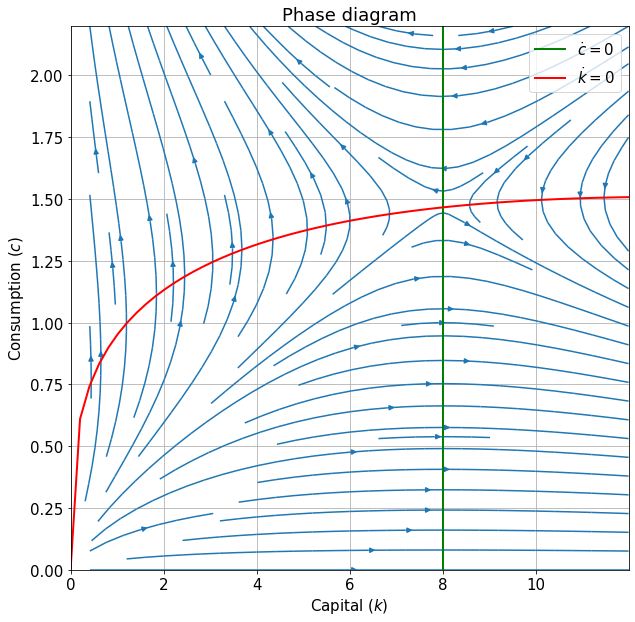

In [14]:
# Plot with streamline
plt.title('Phase diagram')
plt.streamplot(k_grid, c_grid, np.transpose(dk_grid), np.transpose(dc_grid), density=1)
simple_graph()
plt.show()

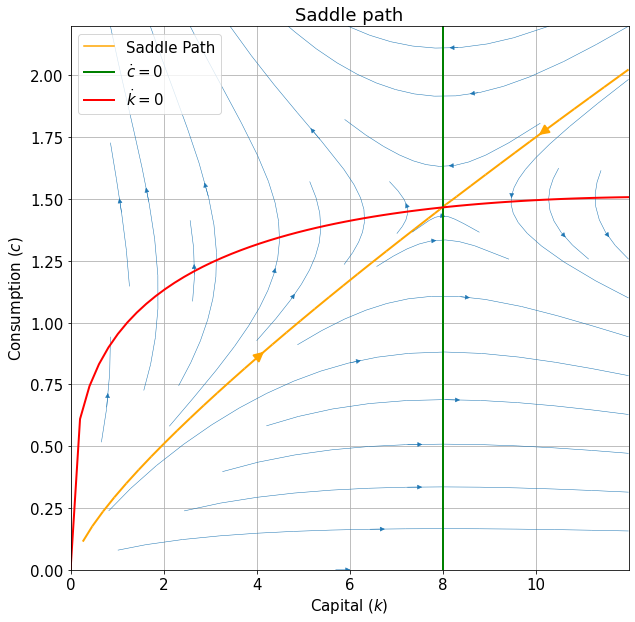

In [15]:
# Plot with saddle path
plt.title('Saddle path')
# To add the saddle path we will cheat a bit. Instead of numerically solving numerically for the saddle path (that for some reason is not working), 
# we will ask for the streamplot to start at the saddle path and integrate backwards, this will generate the left-down part of the saddle path.
# For the right-up part we will add a small perturbation to the saddle path and integrate backwards.
plt.streamplot(k_grid, c_grid, np.transpose(dk_grid), np.transpose(dc_grid), start_points=[ 
                                                                                                (k_ss,c_ss), 
                                                                                                (k_ss+1e-3,c_ss+1e-3)], integration_direction='backward',
                                                                                        broken_streamlines=False, color="orange", arrowsize=2, linewidth=2)
# I also plot the complete streamplot to see the direction of the flow, but with a lower density and smaller arrows to avoid cluttering the plot.
plt.streamplot(k_grid, c_grid, np.transpose(dk_grid), np.transpose(dc_grid), density=0.5, arrowsize=1, linewidth=0.5)
# We add this code below to have the saddle path in the legend
plt.plot([], [], '-', color="orange", label='Saddle Path')
simple_graph()
plt.show()

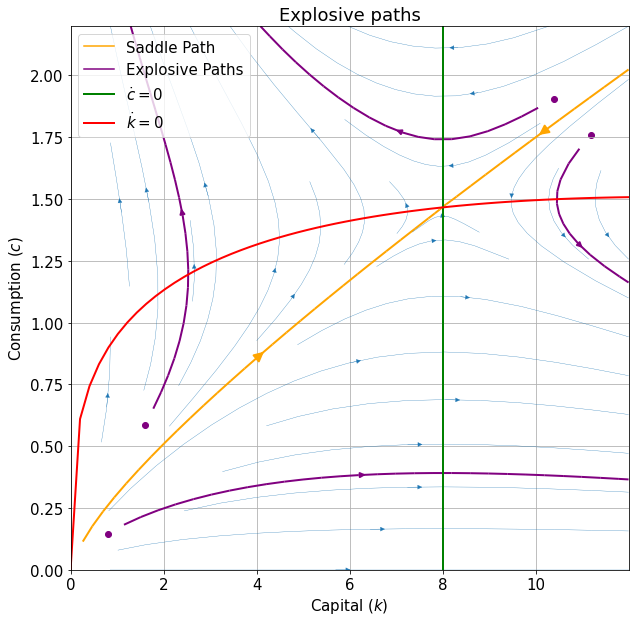

In [16]:
# Now we will do the same thing, but we will also add some explosive paths:

# We will add some arbitrary initial conditions:
arbitrary_initial_conditions = np.array([
                                (k_ss*0.1,c_ss*0.1),
                                (k_ss*0.2,c_ss*0.4),
                                (k_ss*1.3,c_ss*1.3),
                                (k_ss*1.4,c_ss*1.2),
])

# Plot with saddle path
plt.title('Explosive paths')
# Adding some explosive paths using the streamplot function and some arbitrary initial conditions:
plt.streamplot(k_grid, c_grid, np.transpose(dk_grid), np.transpose(dc_grid), start_points=arbitrary_initial_conditions, color='purple', integration_direction='forward',
               broken_streamlines=False, linewidth=2,)
# Also plotting the points of the arbitrary initial conditions:
plt.scatter(arbitrary_initial_conditions[:,0], arbitrary_initial_conditions[:,1], color='purple')
plt.streamplot(k_grid, c_grid, np.transpose(dk_grid), np.transpose(dc_grid), start_points=[ 
                                                                                                (k_ss,c_ss), 
                                                                                                (k_ss+1e-3,c_ss+1e-3)], integration_direction='backward',
                                                                                        broken_streamlines=False, color="orange", arrowsize=2, linewidth=2)
plt.streamplot(k_grid, c_grid, np.transpose(dk_grid), np.transpose(dc_grid), density=0.5, arrowsize=1, linewidth=0.3)
plt.plot([], [], '-', color="orange", label='Saddle Path')
plt.plot([], [], '-', color="purple", label='Explosive Paths')
simple_graph()
plt.show()

In [56]:
# Now, we want to implement these methods into a class, in order to make it easier to use:
class Ramsey:
    def __init__(self, A=1, alpha=0.3, delta=0.05, rho=0.02, theta=0.5, fine=60, far=1.5):
        self.A, self.alpha, self.delta, self.rho, self.theta = A, alpha, delta, rho, theta
        self.fine, self.far = fine, far
        
        # Finding the steady state:
        self.k_ss = (A*alpha/(delta+rho))**(1/(1-alpha))
        self.c_ss = A*k_ss**alpha - delta*k_ss
        
        # Defining the grid for consumption and capital:
        self.k_grid = np.linspace(0, self.k_ss*far, fine)
        self.c_grid = np.linspace(0, self.c_ss*far, fine)
        
        # Setting the nullcine equations:
        self.c_null = (A*alpha/(delta + rho))**(1/(1-alpha))
        self.k_null = A*self.k_grid**alpha - delta*self.k_grid
        
        # Setting the grids to be used in the phase diagram:
        self.M1, self.M2 = np.meshgrid(self.c_grid, self.k_grid)
        
        # Evaluating the differential equations in the grid:
        # Ps: This uses a function that I defined below.
        self.dc_grid, self.dk_grid = self.dc_dk(self.M1, self.M2)
        
        
    # Defining a function that plots the nullcine equations:
    def simple_graph(self):
        plt.plot([self.c_null]*fine, self.c_grid, color = 'green', label='$\\dot c = 0$', linewidth=2)
        plt.plot(self.k_grid, self.k_null, color = 'red', label='$\\dot k = 0$', linewidth=2)
        plt.xlabel('Capital ($k$)')
        plt.ylabel('Consumption ($c$)')
        plt.ylim(0, self.c_grid[-1])
        plt.xlim(0, self.k_grid[-1])
        plt.legend()
        plt.grid()
        
    # Defining the differential equations:
    def dc_dk(self, c,k):
        # Ps: we have some zeros in the grid and this will cause Python to report a warning. 
        # To avoid that we will use the np.errstate function:
        with np.errstate(divide='ignore', invalid='ignore'):
            dc = c*(self.A*self.alpha*k**(self.alpha-1) - self.delta - self.rho)/self.theta
            dk = self.A*k**self.alpha - self.delta*k - c
        return dc, dk
    
    # Function to plot the phase diagram using the quiver function:
    def graph_quiver(self, n=3):
        # I load the simple graph function:
        self.simple_graph()
        # Because the grid is usually too dense, we only plot the n-th arrow:
        plt.quiver(self.M2[::n], self.M1[::n], self.dk_grid[::n], self.dc_grid[::n], 
                   angles = 'xy', scale_units = 'xy', scale = 2.5)
        
    # Function to plot the phase diagram using the streamplot function:
    def graph_streamplot(self):
        # I load the simple graph function:
        self.simple_graph()
        # Plotting the streamplot:
        plt.streamplot(self.k_grid, self.c_grid, np.transpose(self.dk_grid), np.transpose(self.dc_grid), density=1)
    
    # Function to plot the phase diagram with a saddle path:
    def graph_saddle_path(self):        
        # Plotting the streamplot:
        plt.streamplot(self.k_grid, self.c_grid, np.transpose(self.dk_grid), np.transpose(self.dc_grid), start_points=[ 
                                                                                                (self.k_ss,self.c_ss), 
                                                                                                (self.k_ss+1e-2,self.c_ss+1e-2)], integration_direction='backward',
                                                                                        broken_streamlines=False, color="orange", arrowsize=2, linewidth=2)
        # Plloting the old streamplot:
        plt.streamplot(self.k_grid, self.c_grid, np.transpose(self.dk_grid), np.transpose(self.dc_grid), density=0.5, arrowsize=1, linewidth=0.5)
        plt.plot([], [], '-', color="orange", label='Saddle Path')
         # I load the simple graph function:
        self.simple_graph()
    
    # Function to plot the phase diagram with some explosive paths:
    
    def graph_explosive_paths(self, init_cond = 
                              np.array([
                                (k_ss*0.1,c_ss*0.1),
                                (k_ss*0.2,c_ss*0.4),
                                (k_ss*1.3,c_ss*1.3),
                                (k_ss*1.4,c_ss*1.2)])):
        # Adding explosive paths:
        plt.streamplot(self.k_grid, self.c_grid, np.transpose(self.dk_grid), np.transpose(self.dc_grid), start_points=init_cond,
                       color='purple', integration_direction='forward', broken_streamlines=False, linewidth=2)
        # Also plotting the points of the initial conditions:
        plt.scatter(init_cond[:,0], init_cond[:,1], color='purple')
        # Plotting the saddle path:
        plt.streamplot(self.k_grid, self.c_grid, np.transpose(self.dk_grid), np.transpose(self.dc_grid), 
                       start_points=[ (k_ss,c_ss),(k_ss+1e-3,c_ss+1e-3)], 
                       integration_direction='backward',broken_streamlines=False, color="orange", arrowsize=2, linewidth=2)
        plt.plot([], [], '-', color="orange", label='Saddle Path')
        plt.plot([], [], '-', color="purple", label='Explosive Paths')
        self.simple_graph()